# Zeitreihenglättung

Das Notebook ergänzt den Anhang 'Methoden' und widmet sich der Zeitreihenglättung.

# Import

In [1]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go

from resources_geschichtslyrik import *
from resources_statistics import *

In [2]:
meta = pd.read_json(r"../resources/meta.json")

# Korpora

In [3]:
meta_anth = (
    meta
    .query("corpus=='anth'")
    .query("1850 <= year <= 1918")
    .query("geschichtslyrik == 1")
    .drop_duplicates(subset='author_title')
)

In [4]:
ts = pd.DataFrame()
ts.index = pd.Series(range(1850, 1919), name = 'year')

In [5]:
ts['text_count'] = meta_anth.groupby('year').size()
ts['text_count'] = ts['text_count'].fillna(0)
ts['text_sum'] = smooth(ts['text_count'], mode = 'sum')

In [6]:
ts['ballade_count'] = [meta_anth.query("year == @x and gattung.str.contains('Ballade')").shape[0] for x in ts.index]
ts['ballade_sum'] = smooth(ts['ballade_count'], mode = 'sum')
ts['ballade_share'] = ts['ballade_count']/ts['text_count']
ts['ballade_share_smoothed'] = ts['ballade_sum']/ts['text_sum']
ts['ballade_share_smoothed_low'] = [proportion_confint(x, y, 0.1)[0] for x, y in zip(ts['ballade_sum'], ts['text_sum'])]
ts['ballade_share_smoothed_high'] = [proportion_confint(x, y, 0.1)[1] for x, y in zip(ts['ballade_sum'], ts['text_sum'])]

ts['noballade_count'] = [meta_anth.query("year == @x and gattung.str.contains('Ballade', na = False) == False").shape[0] for x in ts.index]
ts['noballade_sum'] = smooth(ts['noballade_count'], mode = 'sum')
ts['noballade_share'] = ts['noballade_count']/ts['text_count']
ts['noballade_share_smoothed'] = ts['noballade_sum']/ts['text_sum']
ts['noballade_share_smoothed_low'] = [proportion_confint(x, y, 0.1)[0] for x, y in zip(ts['noballade_sum'], ts['text_sum'])]
ts['noballade_share_smoothed_high'] = [proportion_confint(x, y, 0.1)[1] for x, y in zip(ts['noballade_sum'], ts['text_sum'])]

In [7]:
ts.loc[1860:1865]

,text_count,text_sum,ballade_count,ballade_sum,ballade_share,ballade_share_smoothed,ballade_share_smoothed_low,ballade_share_smoothed_high,noballade_count,noballade_sum,noballade_share,noballade_share_smoothed,noballade_share_smoothed_low,noballade_share_smoothed_high
year,,,,,,,,,,,,,,
1860,31,308.066564,23,209.096726,0.741935,0.678739,0.634978,0.722500,8,98.969838,0.258065,0.321261,0.277500,0.365022
1861,42,315.714726,31,211.597531,0.738095,0.670217,0.626696,0.713739,11,104.117195,0.261905,0.329783,0.286261,0.373304
1862,42,323.649686,28,211.908541,0.666667,0.654747,0.611276,0.698217,14,111.741145,0.333333,0.345253,0.301783,0.388724
1863,22,314.506249,13,206.446835,0.590909,0.656416,0.612368,0.700463,9,108.059414,0.409091,0.343584,0.299537,0.387632
1864,37,317.299171,15,208.185179,0.405405,0.656116,0.612254,0.699978,22,109.113991,0.594595,0.343884,0.300022,0.387746
1865,18,330.957090,12,208.479752,0.666667,0.629930,0.586275,0.673584,6,122.477338,0.333333,0.370070,0.326416,0.413725


## Anzahl Balladen vs. Nicht-Balladen

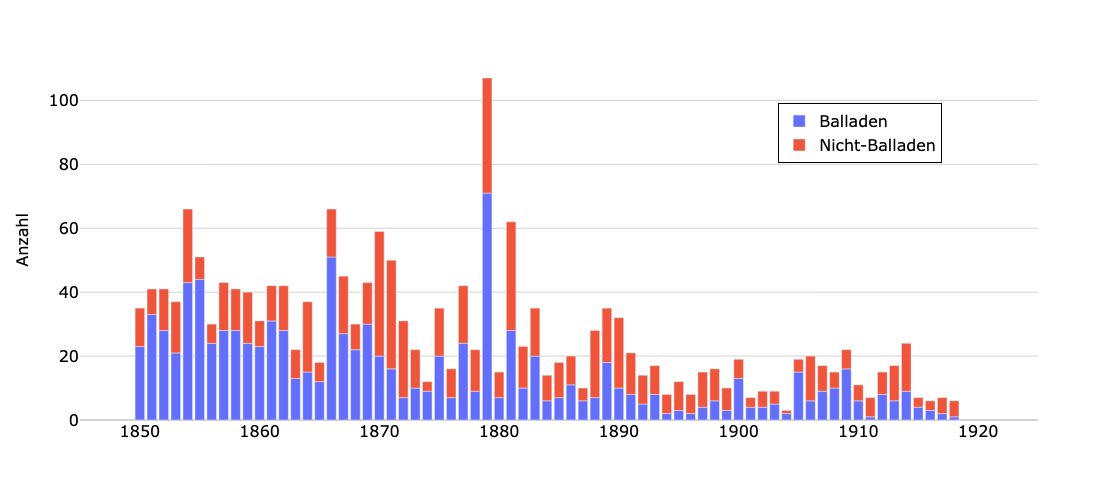

In [12]:
meta_plot = ts.copy()
meta_plot = meta_plot.rename(columns={
    'ballade_count' : 'Balladen', 
    'noballade_count' : 'Nicht-Balladen'
})

fig = px.bar(
    meta_plot,
    y = ['Balladen', 'Nicht-Balladen'],
    labels = {'year' : '', 'variable' : '', 'value' : 'Anzahl'}
)

fig.update_layout(
    width=900, height=500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font = dict(size = 16),
                yanchor="top", y=0.88, xanchor="right", x=0.9),
    xaxis_range = [1845, 1925],
)
fig = update_fig_for_publication(fig)
fig.write_image(f"plots/8.2 Anzahl Balladen.pdf")
fig.show()

## Anteil Balladen (ohne Glättung)

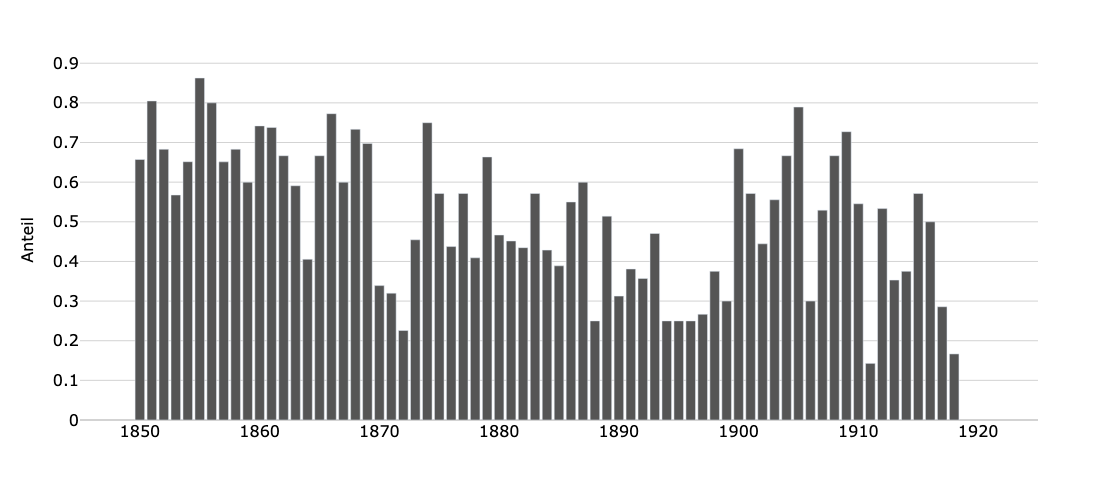

In [13]:
meta_plot = ts.copy()
meta_plot = meta_plot.rename(columns={
    'ballade_share' : 'Balladen', 
    'noballade_share' : 'Nicht-Balladen'
})

fig = px.bar(
    meta_plot,
    y = ['Balladen', 
         # 'Nicht-Balladen'
        ],
    labels = {'year' : '', 'variable' : '', 'value' : 'Anteil'},
)

fig.update_layout(
    width=900, height=500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font = dict(size = 16)),
    showlegend = False,
    xaxis_range = [1845, 1925],
)

fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/8.2 Anteil Balladen (ohne Glättung).pdf")
fig.show()

## Anteil Balladen (mit Glättung)

In [10]:
meta_plot = ts.copy()
meta_plot = meta_plot.rename(columns={
    'ballade_share_smoothed' : 'Balladen', 
    'noballade_share_smoothed' : 'Nicht-Balladen'
})

fig = px.bar(
    meta_plot,
    y = ['Balladen', 
         # 'Nicht-Balladen'
        ],
    labels = {'year' : '', 'variable' : '', 'value' : 'Anteil'}
)

fig.update_layout(
    width=900, height=500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font = dict(size = 16)),
    showlegend = False,
    xaxis_range = [1845, 1925],
)
fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/8.2 Anteil Balladen (mit Glättung).pdf")
fig.show()

## Anteil Balladen (mit Glättung und Konfidenzintervall)

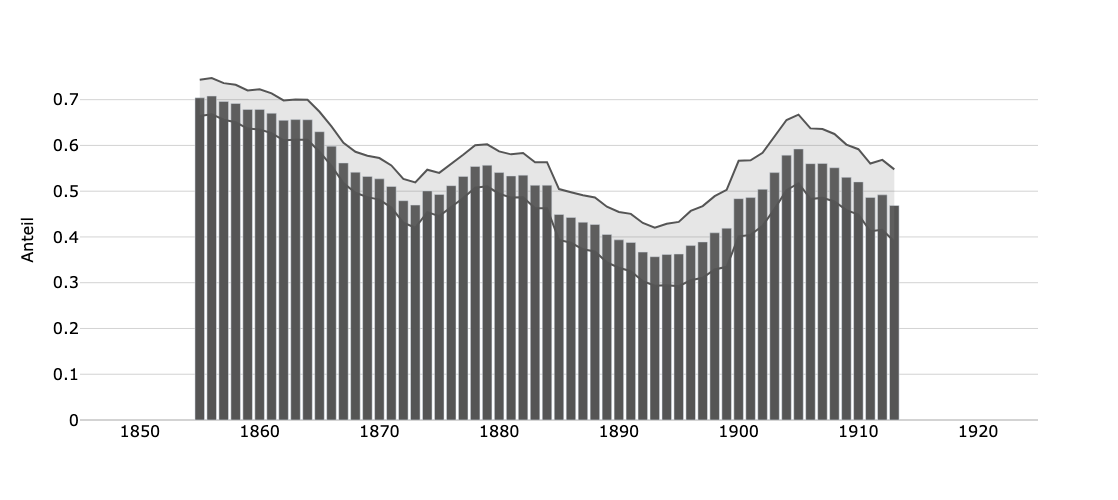

In [11]:
meta_plot = ts.copy()
meta_plot = meta_plot.rename(columns={
    'ballade_share_smoothed' : 'Balladen', 
    'noballade_share_smoothed' : 'Nicht-Balladen'
})

fig = px.bar(
    meta_plot,
    y = ['Balladen', 
         # 'Nicht-Balladen'
        ],
    labels = {'year' : '', 'variable' : '', 'value' : 'Anteil'}
)

confint_columns = [
    ['ballade_share_smoothed_low', 'ballade_share_smoothed_high'],
]

# confint
for i, confint_column in enumerate(confint_columns):
    fig.add_trace(
        go.Scatter(
            x=meta_plot.index.tolist(),
            y=ts[confint_column[0]].tolist(),
            mode='lines',
            line=dict(width=2, color='black'),
            showlegend=False
        ))
    fig.add_trace(
        go.Scatter(
            x=meta_plot.index.tolist(),
            y=ts[confint_column[1]].tolist(),
            line=dict(width=2, color='black'),
            mode='lines',
            fillcolor="rgba(128,128,128,0.2)",
            fill='tonexty',
            showlegend=False
        )
    )

fig.update_layout(
    width=900, height=500,
    xaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    yaxis=dict(tickfont=dict(size=16), titlefont=dict(size=16)),
    legend=dict(font = dict(size = 16)),
    showlegend = False,
    xaxis_range = [1845, 1925],
)
fig = update_fig_for_publication(fig, make_grey=True)
fig.write_image(f"plots/8.2 Anteil Balladen (mit Glättung und Konfidenzintervall).pdf")
fig.show()